In [199]:
from data_reader import LMDBReader, CCPDHelper

# your path to data
train_path = r'/home/taysin/Documents/course_ocr/task2/data/CCPD/train.lmdb'
gt_path = './gt.txt'

In [200]:
import cv2
import numpy as np
from tqdm import tqdm

### Data tools demonstration

In [201]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = CCPDHelper(train_reader)

In [202]:
train_helper.size()

199996

In [203]:
names = train_reader.namelist()
SEED = 42
TRAIN_PART = 0.8

In [204]:
rng = np.random.default_rng(SEED)
permutation = rng.permutation(len(names))
train_size = int(len(names) * 0.8)
train_names = [names[i] for i in permutation[:train_size]]
val_names = [names[i] for i in permutation[train_size:]]

In [205]:
train_helper = CCPDHelper(train_reader, train_names)
val_helper = CCPDHelper(train_reader, val_names)

In [206]:
img0, txt0 = train_helper.item(6)

In [207]:
txt0

'皖A3Q655'

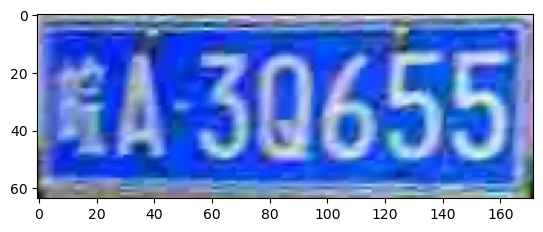

In [208]:
from matplotlib import pyplot as plt
plt.imshow(img0)

In [209]:
img0.shape

(64, 172, 3)

In [210]:
from data_reader import provinces, ads

chars = list(set(provinces + ads))
id2chars = {i:v for i, v in enumerate(chars)}
chars2id = {k:i for i, k in id2chars.items()}

In [211]:
id2chars, chars2id

({0: 'H',
  1: '苏',
  2: 'V',
  3: '桂',
  4: '4',
  5: '青',
  6: '甘',
  7: '闽',
  8: '8',
  9: '吉',
  10: '赣',
  11: 'Q',
  12: '警',
  13: '0',
  14: '陕',
  15: 'Y',
  16: 'W',
  17: '津',
  18: '鄂',
  19: 'F',
  20: 'K',
  21: 'Z',
  22: '蒙',
  23: 'B',
  24: '川',
  25: 'X',
  26: '3',
  27: 'U',
  28: 'D',
  29: '豫',
  30: 'E',
  31: 'R',
  32: '渝',
  33: '晋',
  34: '新',
  35: 'S',
  36: 'T',
  37: '鲁',
  38: '浙',
  39: '沪',
  40: '京',
  41: 'N',
  42: '5',
  43: '贵',
  44: 'P',
  45: '7',
  46: 'M',
  47: 'O',
  48: 'A',
  49: '辽',
  50: '皖',
  51: '粤',
  52: '2',
  53: '冀',
  54: 'J',
  55: 'G',
  56: '1',
  57: '云',
  58: '6',
  59: '宁',
  60: '琼',
  61: '学',
  62: '9',
  63: 'L',
  64: 'C',
  65: '藏',
  66: '黑',
  67: '湘'},
 {'H': 0,
  '苏': 1,
  'V': 2,
  '桂': 3,
  '4': 4,
  '青': 5,
  '甘': 6,
  '闽': 7,
  '8': 8,
  '吉': 9,
  '赣': 10,
  'Q': 11,
  '警': 12,
  '0': 13,
  '陕': 14,
  'Y': 15,
  'W': 16,
  '津': 17,
  '鄂': 18,
  'F': 19,
  'K': 20,
  'Z': 21,
  '蒙': 22,
  'B': 23,
  '川': 

In [212]:
import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [213]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CCPDDataset(Dataset):
    def __init__(self, helper, chars2id) -> None:
        super().__init__()

        self.helper = helper
        self.chars2id = chars2id
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, txt = self.helper.item(idx)
        img_t = self.transforms(img)
        tokenized = torch.tensor([self.chars2id[x] for x in txt])

        return img_t, tokenized

In [216]:
train_dataset = CCPDDataset(train_helper, chars2id)
val_dataset = CCPDDataset(val_helper, chars2id)

BATCH_SIZE = 128
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [185]:
from torchvision import models

class Model(nn.Module):
    def __init__(self, n_classes: int, hidden_dim: int = 256, seq_l: int = 7) -> None:
        super().__init__()

        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
        
        seq_i = nn.Sequential(
            nn.Linear(2048, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, hidden_dim * 2)
        )
        self.seq_l = seq_l
        self.seqs = nn.ModuleList([seq_i for _ in range(self.seq_l)])

        self.act = nn.LeakyReLU(0.2)

        self.lstm = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.resnet(x).flatten(1)
        x = self.act(x)
        
        seq = [self.seqs[i](x).to(x.device).unsqueeze(1) for i in range(self.seq_l)]
        
        x = torch.cat(seq, dim=1).to(x.device)
        x, _ = self.lstm(x)

        return self.head(self.act(x)).permute(0, 2, 1)


In [186]:
import lightning as L
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Clf(L.LightningModule):
    def __init__(self, n_classes, hidden_dim: int = 256):
        super().__init__()
        self.n_classes = n_classes
        self.model = Model(n_classes, hidden_dim=hidden_dim)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets) 
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets) 
        self.log("val_loss", loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4, weight_decay=5e-4)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1, threshold=0.1, cooldown=1, min_lr=1e-5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

In [20]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [188]:
clf = Clf(len(chars), id2chars, hidden_dim=512)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/taysin/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.6MB/s]


In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="val_loss", save_top_k=3, filename='{epoch}-{val_loss:.4f}', verbose=True, dirpath="/kaggle/working/")

max_epochs = 6

trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=50, callbacks=[checkpoint_callback])
trainer.fit(
    clf,
    train_dl,
    val_dl
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-05-04 16:04:12.391376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 16:04:12.391474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 16:04:12.521402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 1250: 'val_loss' reached 0.54072 (best 0.54072), saving model to '/kaggle/working/epoch=0-val_loss=0.5407.ckpt' as top 3
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parame

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 2500: 'val_loss' reached 0.13655 (best 0.13655), saving model to '/kaggle/working/epoch=1-val_loss=0.1365.ckpt' as top 3
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parame

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 3750: 'val_loss' reached 0.06697 (best 0.06697), saving model to '/kaggle/working/epoch=2-val_loss=0.0670.ckpt' as top 3
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parame

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 5000: 'val_loss' reached 0.05162 (best 0.05162), saving model to '/kaggle/working/epoch=3-val_loss=0.0516.ckpt' as top 3
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parame

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 6250: 'val_loss' reached 0.03877 (best 0.03877), saving model to '/kaggle/working/epoch=4-val_loss=0.0388.ckpt' as top 3
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parame

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 7500: 'val_loss' reached 0.03843 (best 0.03843), saving model to '/kaggle/working/epoch=5-val_loss=0.0384.ckpt' as top 3
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.


### Evaluation

In [264]:
# Evaluating from checkpoint and specified id2chars & chars2id
id2chars, chars2id = ({0: 'Y',
  1: '贵',
  2: 'W',
  3: '冀',
  4: '9',
  5: '京',
  6: '闽',
  7: '琼',
  8: '宁',
  9: '学',
  10: 'O',
  11: '沪',
  12: '5',
  13: '豫',
  14: '4',
  15: '7',
  16: '警',
  17: '粤',
  18: '渝',
  19: '晋',
  20: '辽',
  21: '青',
  22: 'N',
  23: '黑',
  24: 'B',
  25: 'Q',
  26: '湘',
  27: 'Z',
  28: '6',
  29: '2',
  30: '津',
  31: 'H',
  32: 'K',
  33: '赣',
  34: 'S',
  35: 'A',
  36: 'E',
  37: '甘',
  38: 'U',
  39: '川',
  40: '苏',
  41: 'D',
  42: '鲁',
  43: 'L',
  44: '鄂',
  45: '藏',
  46: '皖',
  47: '陕',
  48: '蒙',
  49: '云',
  50: '吉',
  51: 'P',
  52: 'M',
  53: 'J',
  54: 'V',
  55: '8',
  56: '3',
  57: '浙',
  58: '新',
  59: 'C',
  60: 'G',
  61: 'X',
  62: '0',
  63: 'F',
  64: 'T',
  65: '桂',
  66: 'R',
  67: '1'},
 {'Y': 0,
  '贵': 1,
  'W': 2,
  '冀': 3,
  '9': 4,
  '京': 5,
  '闽': 6,
  '琼': 7,
  '宁': 8,
  '学': 9,
  'O': 10,
  '沪': 11,
  '5': 12,
  '豫': 13,
  '4': 14,
  '7': 15,
  '警': 16,
  '粤': 17,
  '渝': 18,
  '晋': 19,
  '辽': 20,
  '青': 21,
  'N': 22,
  '黑': 23,
  'B': 24,
  'Q': 25,
  '湘': 26,
  'Z': 27,
  '6': 28,
  '2': 29,
  '津': 30,
  'H': 31,
  'K': 32,
  '赣': 33,
  'S': 34,
  'A': 35,
  'E': 36,
  '甘': 37,
  'U': 38,
  '川': 39,
  '苏': 40,
  'D': 41,
  '鲁': 42,
  'L': 43,
  '鄂': 44,
  '藏': 45,
  '皖': 46,
  '陕': 47,
  '蒙': 48,
  '云': 49,
  '吉': 50,
  'P': 51,
  'M': 52,
  'J': 53,
  'V': 54,
  '8': 55,
  '3': 56,
  '浙': 57,
  '新': 58,
  'C': 59,
  'G': 60,
  'X': 61,
  '0': 62,
  'F': 63,
  'T': 64,
  '桂': 65,
  'R': 66,
  '1': 67})

clf = Clf.load_from_checkpoint("./epoch=5-val_loss=0.0384.ckpt", n_classes=len(chars), id2chars=id2chars, hidden_dim=512)

In [265]:
test_path = r'/home/taysin/Documents/course_ocr/task2/data/CCPD/test.lmdb'
pred_path = './pred.txt'

In [266]:
test_reader = LMDBReader(test_path)
test_reader.open()
test_reader = CCPDHelper(test_reader, test_reader.namelist())

In [267]:
test_dataset = CCPDDataset(test_reader, chars2id)
test_dl = DataLoader(test_dataset, batch_size=16)

In [268]:
trainer = Trainer()
predicts = trainer.predict(clf, test_dl)

/home/taysin/anaconda3/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/taysin/anaconda3/lib/python3.11/site-packages/ ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/taysin/Documents/course_ocr/task2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/taysin/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[[46 35 36 52 15 56 15]
 [46 35  2 62 56 62 62]
 [46 35 15 53 56 56  4]
 [46 35 22 55 67 28 12]
 [46 35 61 14 29 56 66]
 [46 35 55 15 62 41 15]
 [ 5 51 51 29 34 12 12]
 [46 66 43 29 29 29 31]
 [46 35  0 67 35 12  4]
 [46 35 29 67 28 32 12]
 [46 31 31 53 62 62 29]
 [46 35  2 28 61 62 62]
 [46 35 24 67 22 28 67]
 [46 35 35 22 56 15 29]
 [46 35  4 56 34 28 29]
 [46 35 60 55 22 28 15]]
[[46 35 14 14 29 15 15]
 [46 35 36 22 29  4 28]
 [40 35 14 14 55 27 55]
 [46 35 56 56 67 12  4]
 [46 35  4 54 55  4 15]
 [46 52 53 55 56 28 55]
 [46 35 27  4 27 15 15]
 [46 35 31 31 28 29 55]
 [46 35 53 29 12 12 12]
 [46 35 15 55 29 52 29]
 [46 35 43 31 62 56 28]
 [46 35  4 67 55 55  4]
 [46 35 52 61 61  4 12]
 [46 35 61 63 29 14 28]
 [46 35 55  0 55 28 15]
 [46 35 64 62 55 67 59]]
[[46 35 28 43 55 15 12]
 [46 35  0 29 56 14 56]
 [46 35 60 29 12 55 32]
 [46 35 22 28 55 14 12]
 [46 35 43 36 12 67 28]
 [11 59 28 32 55 29 29]
 [46 35 27 15 14 15 14]
 [46 35 52 15 27 15 15]
 [46 35 66 29 15 43 67]
 [46 35 34 52 

In [269]:
i = 0

with open(pred_path, 'w') as fo:
    for batch_pred in tqdm(predicts):
        for pred in batch_pred:
            fo.write(str(i) + ' ' + pred + '\n')
            i += 1

100%|██████████| 1254/1254 [00:00<00:00, 117829.14it/s]


In [270]:
from course_ocr_t2.evaluate import evaluate
evaluate('./gt.txt', './pred.txt') * 100

96.7833632555356